# Reachability Deep Dive

Let’s see if we can discern the properties of the reachable set for k<=10 prompt
tokens by focusing on just a few initial states x_0, but many y* for each x_0.
We are looking for a clean decision boundary where at a certain CE loss on
P(y*_i | x_0), we see that below that it’s solvable in k<=10 above it’s not. 

**Creating the dataset**
 - [ ] Extract 20 random x_0 from wiki5k. Based on some skip_value, we will select
every token of rank i where i % skip_value = 0 as one of the y* values
corresponding to x_0. 
    - [ ] We want 5000 total instances to distribute over the A100’s (probably 8
    of 64 total). So let’s use 5000/20 = 250 y* values for each x_0. 
    - [ ] Since there are 65,536 tokens for Falcon-7b, we would need a
    skip_value satisfying 65536 / skip_value = 250, which implies skip_value =
    65536/250 = 262.144 = 265 = skip_value.

```bash
>>> python3 scripts/generate_deep_dive.py \
    --input_file results/wiki_reachability/k10_falcon7b_wiki5k.csv \
    --output_file results/deep_dive/falcon7b_skip265_states20.csv \
    --model falcon-7b \
    --skip 265 \
    --num_unique_states 20
```

**Controllability Experiments**

We are now ready to run the `scripts/reachability.py` script on this dataset. 
I'll make a `falcon_deepdive.sh` script so we can run it more easily with an 
automated naming convention for the chunks run by sub-workers. Let's aim for 
running workers 0-7 of 64 -- so we would be solving 1/8 of the dataset, which will 
hopefully be done within the night. It's really important that I can check on 
this first thing in the morning to triage the remaining experiments. 

```bash
CUDA_VISIBLE_DEVICES=0 bash scripts/deep_dive_falcon7b.sh 0 64  # ran at ~4:30a on Wed Nov 15
CUDA_VISIBLE_DEVICES=1 bash scripts/deep_dive_falcon7b.sh 1 64
CUDA_VISIBLE_DEVICES=2 bash scripts/deep_dive_falcon7b.sh 2 64
CUDA_VISIBLE_DEVICES=3 bash scripts/deep_dive_falcon7b.sh 3 64


CUDA_VISIBLE_DEVICES=0 bash scripts/deep_dive_falcon7b.sh 4 64  # ran at ~4:30a on Wed Nov 15
CUDA_VISIBLE_DEVICES=1 bash scripts/deep_dive_falcon7b.sh 5 64
CUDA_VISIBLE_DEVICES=2 bash scripts/deep_dive_falcon7b.sh 6 64
CUDA_VISIBLE_DEVICES=3 bash scripts/deep_dive_falcon7b.sh 7 64
```

**Experiment Analysis**
Let's see if there's a cutoff value in terms of CE loss (or token rank) 
for the assembled dataframe.


In [26]:
# Import box 
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

## 0: Global Plotting Functions

In [6]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in
def overview_report(df_in): 
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 4: ", len(df_in[df_in['prompt_length'] <= 4]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [7]:
def k_epsilon_line_plot(df_in,
                        title="TITLE",
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'Question Length {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(epsilon)]')
    else:
        plt.ylabel('Portion Incorrect [epsilon]')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [8]:
def loss_k_correlation_plots(df_in, 
                             suptitle="TITLE", 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    

# 1: Falcon-7b Experiments

In [4]:
# Load in the data
file_path = r'falcon-7b/dive1_*_of_64.csv'
# use glob to get the list of files matching the file path regex string
file_list = glob.glob(file_path)
assert len(file_list) > 4

# now we read in all the files into a dataframe
dive1_df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in file_list], ignore_index = True)

dive1_df.head()

,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",allot,48230,12.0625,gcg,***,"[10561, 84, 15453, 48230, 14450, 34293, 2303, ...",8,0.921875,False,True,8
1,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",puls,26780,16.5000,gcg,famously,"[38991, 30256, 12727, 42248, 37891, 31413, 256...",10,2.265625,False,True,8
2,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",weight,6197,18.1250,gcg,ensembles,"[64480, 45526, 24861, 47758, 6220, 16616, 4096...",10,8.125000,False,False,8
3,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",Entscheidung,64787,19.7500,gcg,Produ,"[21938, 22572, 38614, 2918, 43874, 63710, 1738...",10,7.218750,False,False,8
4,had been killed during the previous six months,"[618, 650, 6109, 1365, 248, 2732, 2972, 2137]",owes,45967,14.9375,gcg,Eat,"[49272, 42477, 6234, 12280, 47814, 45842, 2903...",10,4.531250,False,False,8


In [10]:
# Save the dataframe to a csv file 
output_path = 'falcon-7b/dive1.csv'
# check if it exists
if os.path.exists(output_path):
    print("File already exists")
else: 
    print(f"Saving dive1 to {output_path}")
    dive1_df.to_csv(output_path, index=False, lineterminator='\n')

Saving dive1 to falcon-7b/dive1.csv


Let's now create a version of the `dive1.csv` dataset with the logits and 
rankings: 
```bash
>>> python3 scripts/add_logits.py \
    --input_file results/deep_dive/falcon-7b/dive1.csv \
    --output_file results/deep_dive/falcon-7b/ranked_dive1.csv \
    --model falcon-7b
```

Now we can load in the ranked csv from `falcon-7b/ranked_dive1.csv`

In [15]:
ranked_dive1_df = pd.read_csv('falcon-7b/ranked_dive1.csv', lineterminator='\n')
overview_report(ranked_dive1_df)

Mean prompt correct (epsilon): 	 0.4642857142857143
Mean prompt correct with k <= 4:  0.15097402597402598
Mean base correct: 		 0.00487012987012987
Mean prompt length: 		 8.25487012987013


In [20]:
# Let's see if we can get a k-epsilon plot for just one question 
question_ids_0 = ranked_dive1_df['question_ids'].unique().tolist()[0]
question_ids_0
df_filtered = ranked_dive1_df[ranked_dive1_df['question_ids'] == question_ids_0]

<Axes: >

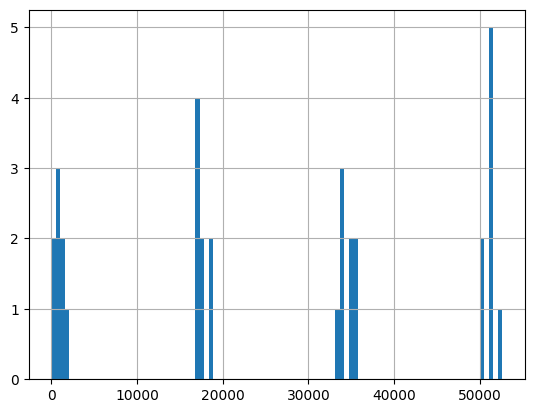

In [24]:
# Let's make a histogram of the 'base_rank' column 
df_filtered['base_rank'].hist(bins=100)
# Note that the skips are because we are only running worker 0-7 of 64. 

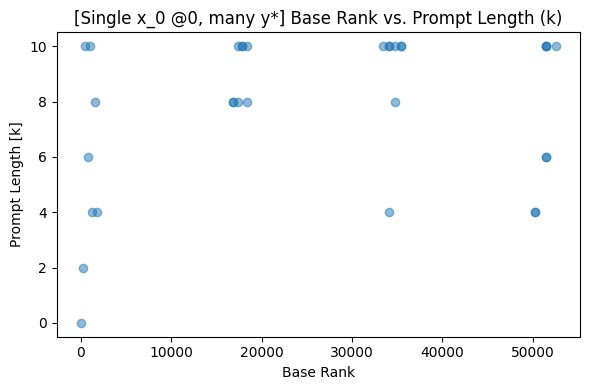

Pearson correlation coefficient: 0.25
Length of solved_df:  20
[SOLVED @0] Pearson correlation coefficient: 0.05


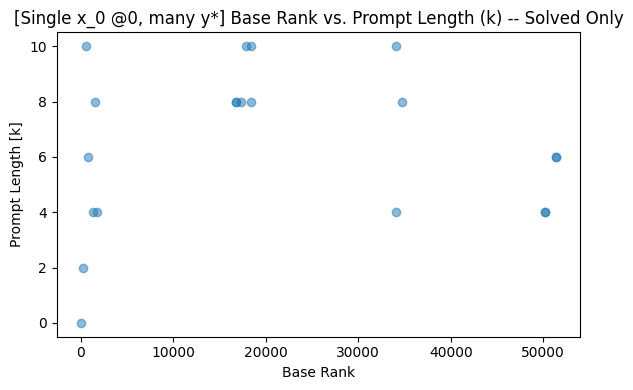

In [35]:
# Let's view the relationship between base_rank and prompt_length 
num_unique = ranked_dive1_df['question_ids'].nunique()

correlations = []
solved_correlations = []

for i in range(num_unique): 
    # Let's see if we can get a k-epsilon plot for just one question 
    question_ids_0 = ranked_dive1_df['question_ids'].unique().tolist()[i]
    question_ids_0
    df_filtered = ranked_dive1_df[ranked_dive1_df['question_ids'] == question_ids_0]

    plt.figure(figsize=(6, 4))
    plt.scatter(df_filtered['base_rank'], df_filtered['prompt_length'], alpha=0.5)
    plt.xlabel('Base Rank')
    plt.ylabel('Prompt Length [k]')
    plt.title(f'[Single x_0 @{i}, many y*] Base Rank vs. Prompt Length (k)')
    plt.tight_layout()
    plt.show()

    # Print the pearson correlation
    corr = df_filtered['base_rank'].corr(df_filtered['prompt_length'])
    print(f'Pearson correlation coefficient: {corr:.2f}')
    correlations.append(corr)

    # Let's see the same thing but only for the "solved" instances
    solved_df = df_filtered[df_filtered['prompt_correct'] == 1]
    print("Length of solved_df: ", len(solved_df))

    plt.figure(figsize=(6, 4))
    plt.scatter(solved_df['base_rank'], solved_df['prompt_length'], alpha=0.5)
    plt.xlabel('Base Rank')
    plt.ylabel('Prompt Length [k]')
    plt.title(f'[Single x_0 @{i}, many y*] Base Rank vs. Prompt Length (k) -- Solved Only')
    plt.tight_layout()

    # Print the pearson correlation
    corr = solved_df['base_rank'].corr(solved_df['prompt_length'])
    print(f'[SOLVED @{i}] Pearson correlation coefficient: {corr:.2f}')
    solved_correlations.append(corr)
    break
    




In [33]:
correlations

[0.25019510532241096,
 0.10812163655407842,
 0.32477698890113543,
 -0.030271025540149807,
 nan,
 0.24787662534055682,
 0.6413809632314939,
 0.15538763788270682,
 0.11533535522261065,
 -0.06281097107017429,
 0.2615560900376843,
 0.496275220540082,
 -0.12255171623726963,
 0.022623872646541494,
 0.6237156698398285,
 0.04564096892864044,
 0.1952495547064449,
 nan,
 0.3316908744782615,
 0.36447076811714474]

In [34]:
solved_correlations

[0.04934965626968389,
 0.02511714428808888,
 0.42657041182537403,
 -0.06592068406192199,
 nan,
 0.8660254037844386,
 0.5315706850333554,
 0.2840839937500736,
 0.36403804536556295,
 -0.11332082021957209,
 0.21551746686413809,
 0.48910398750623385,
 -0.8830462898277912,
 -0.026636941615553536,
 0.5350405390199586,
 -0.0665138843944252,
 0.014185647617048361,
 nan,
 0.47773450686946517,
 0.17269963194161977]

Classifier time -- can we predict solvability on a single $x_0$ based on the 
given $y^*$'s base loss, base rank, and base entropy? 

In [42]:
solve_fractions = []
for i in range(ranked_dive1_df['question_ids'].nunique()): 
    df_filtered = ranked_dive1_df[ranked_dive1_df['question_ids'] == ranked_dive1_df['question_ids'].unique().tolist()[i]]
    fraction_solved = len(df_filtered[df_filtered['prompt_correct'] == 1]) / len(df_filtered)
    print(f"Fraction of solvable instances for quesiton {i}: ", fraction_solved)
    solve_fractions.append(fraction_solved)
    # print(f"Fraction of solvable instances for quesiton {i}")

Fraction of solvable instances for quesiton 0:  0.625
Fraction of solvable instances for quesiton 1:  0.71875
Fraction of solvable instances for quesiton 2:  0.9375
Fraction of solvable instances for quesiton 3:  0.4375
Fraction of solvable instances for quesiton 4:  0.0
Fraction of solvable instances for quesiton 5:  0.10714285714285714
Fraction of solvable instances for quesiton 6:  0.6785714285714286
Fraction of solvable instances for quesiton 7:  0.6875
Fraction of solvable instances for quesiton 8:  0.40625
Fraction of solvable instances for quesiton 9:  0.90625
Fraction of solvable instances for quesiton 10:  0.46875
Fraction of solvable instances for quesiton 11:  0.3125
Fraction of solvable instances for quesiton 12:  0.125
Fraction of solvable instances for quesiton 13:  0.34375
Fraction of solvable instances for quesiton 14:  0.8125
Fraction of solvable instances for quesiton 15:  0.46875
Fraction of solvable instances for quesiton 16:  0.625
Fraction of solvable instances fo

## What makes a given $x_0$ "easy to control"? 
Some of these questions have a super high % of the desired final tokens reached. 
Is there a pattern in there? Maybe they initially had super high entropy next 
token distributions...

In [44]:
# Interesting thought: Can we predict the fraction of solved instances based on 
# the base entropy? 

# 1: Collect the base entropies for each of the unique question_ids 
base_entropies = []
for question_ids in ranked_dive1_df['question_ids'].unique().tolist(): 
    df_filtered = ranked_dive1_df[ranked_dive1_df['question_ids'] == question_ids]
    base_entropies.append(df_filtered['base_entropy'].unique().tolist()[0])
    # print(df_filtered['base_entropy'].unique().tolist()[0])

R^2 value:  0.5219013174914717


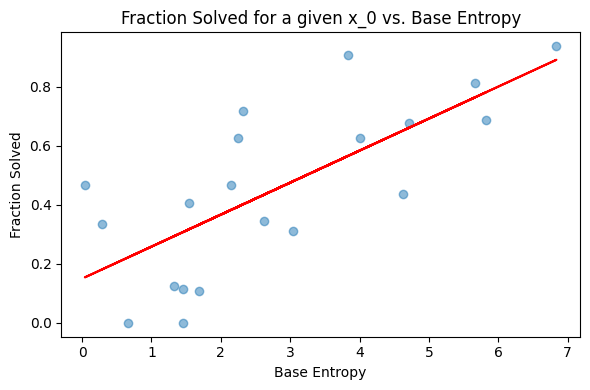

In [48]:
# Now we can try to predict solve_fractions based on base_entropies
# let's just plot them first 
# plt.figure(figsize=(6, 4))
# plt.scatter(base_entropies, solve_fractions, alpha=0.5)
# plt.xlabel('Base Entropy')
# plt.ylabel('Fraction Solved')
# plt.title(f'Fraction Solved vs. Base Entropy')
# plt.tight_layout()

# Add a linear regression fit 
from sklearn.linear_model import LinearRegression
import numpy as np

# reshape the base_entropies to be a 2D array
base_entropies = np.array(base_entropies).reshape(-1, 1)
solve_fractions = np.array(solve_fractions).reshape(-1, 1)

# assertion that they're the right shape 
assert base_entropies.shape == (len(base_entropies), 1)
assert solve_fractions.shape == (len(solve_fractions), 1)

# Create the linear regression model
model = LinearRegression()
model.fit(base_entropies, solve_fractions)

# Make predictions
predictions = model.predict(base_entropies)

# let's get the r^2 value 
r2 = model.score(base_entropies, solve_fractions)
print("R^2 value: ", r2)


# Plot the predictions on top of the scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(base_entropies, solve_fractions, alpha=0.5)
plt.plot(base_entropies, predictions, c='r')
plt.xlabel('Base Entropy')
plt.ylabel('Fraction Solved')
plt.title(f'Fraction Solved for a given x_0 vs. Base Entropy')
plt.tight_layout()



In [56]:
# can we train a classifier to predict whether a prompt is solvable or not 
# based on base_loss, base_rank, and base_entropy? 
# Goal: predict 'prompt_correct' from 'base_loss', 'base_rank', and 'base_entropy'
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# try an MLP too 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

df_filtered = ranked_dive1_df



X = df_filtered[['base_loss', 'base_rank', 'base_entropy']]
# scale X 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df_filtered['prompt_correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_logistic = clf.predict(X_test)

# Try with k-fold cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print("Cross-validation scores: ", scores)


# Let's also try with an SVC
from sklearn.svm import SVC
clf = SVC(random_state=0).fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)





print("=== LOGISTIC REGRESSION FOR PREDICTING SOLVABILITY WITH K<10 -- EVENLY DISTRIBUTED Y* ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_logistic))
print("Precision: ", precision_score(y_test, y_pred_logistic))
print("Recall: ", recall_score(y_test, y_pred_logistic))
print("F1: ", f1_score(y_test, y_pred_logistic))


print("=== SVC FOR PREDICTING SOLVABILITY WITH K<10 -- EVENLY DISTRIBUTED Y* ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("Precision: ", precision_score(y_test, y_pred_svm))
print("Recall: ", recall_score(y_test, y_pred_svm))
print("F1: ", f1_score(y_test, y_pred_svm))

# what fraction of the test set is solvable?
print("\n\nFraction of test set that is solvable: ", y_test.mean())
# what fraction of the training set is solvable
print("Fraction of training set that is solvable: ", y_train.mean())

Cross-validation scores:  [0.66935484 0.71544715 0.74796748 0.63414634 0.69918699]
=== LOGISTIC REGRESSION FOR PREDICTING SOLVABILITY WITH K<10 -- EVENLY DISTRIBUTED Y* ===
Accuracy:  0.6854838709677419
Precision:  0.7111111111111111
Recall:  0.5517241379310345
F1:  0.6213592233009709
=== SVC FOR PREDICTING SOLVABILITY WITH K<10 -- EVENLY DISTRIBUTED Y* ===
Accuracy:  0.6854838709677419
Precision:  0.6862745098039216
Recall:  0.603448275862069
F1:  0.6422018348623854


Fraction of test set that is solvable:  0.46774193548387094
Fraction of training set that is solvable:  0.4634146341463415
